In [ ]:
# Load library
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import h5py
import time
from sklearn import multioutput
import xgboost as xgb
from google.colab import files
from numpy import savetxt

In [ ]:
# Seed
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763


In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Data')
Data1 = loadmat('p5763_Set1_Inputs.mat')
Data2 = loadmat('p5763_Set1_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['K','V','AE','Amp','SS','TTF']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
             K      V    AE      Amp
0     5957.24  17.78  2.00  2090.29
1     5960.89  17.79  2.00  2072.79
2     6214.84  17.81  2.00  2078.77
3     4543.97  17.74  2.00  2085.99
4     4554.15  17.76  1.67  2066.37
...       ...    ...   ...      ...
9495  1033.99  16.82  2.00  1720.64
9496  1032.72  16.81  2.00  1742.58
9497  1032.13  16.81  1.67  1732.37
9498  1032.36  16.81  1.67  1693.09
9499  1114.37  16.83  1.50  1704.66

[9500 rows x 4 columns]
Target Data:
         SS   TTF
0     6.05  0.00
1     6.06  0.00
2     6.06  0.00
3     6.07  0.00
4     6.07  0.00
...    ...   ...
9495  5.92  6.55
9496  5.92  6.45
9497  5.93  6.34
9498  5.93  6.23
9499  5.94  6.12

[9500 rows x 2 columns]


In [ ]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix, -2:]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Preprocessing
arr = df.to_numpy()
n_steps = 100
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (9400, 100, 4)
Target shape, Y =  (9400, 2)
After reshaping, X =  (9400, 400)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state = 0, test_size=0.111, shuffle=False)

# # Select Train
X_train = X_train[6580:7520]
Y_train = Y_train[6580:7520]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples:", np.shape(Y_train))
print("Validation output samples:", np.shape(Y_val))
print("Testing output samples:", np.shape(y_test))

Training input samples: (940, 400)
Validation input samples: (940, 400)
Testing input samples: (940, 400)
Training output samples: (940, 2)
Validation output samples: (940, 2)
Testing output samples: (940, 2)


In [ ]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
model = multioutput.MultiOutputRegressor(model)
start_time = time.time()
model.fit(X_train, Y_train, verbose=True)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

---Training time: 64.56775475 seconds ---


In [ ]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))

ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[0]))

ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[1]))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))

ss_val_r2 = r2_score(Y_val[:,0], y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[0]))

ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[1]))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ss_test_r2 = r2_score(y_test[:,0], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[0]))

ttf_test_r2 = r2_score(y_test[:,1], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[1]))

## Print
print('Shear Stress')
print('R2 score:', ss_train_r2, ss_val_r2 ,ss_test_r2, '\nRMSE:', ss_train_rmse, ss_val_rmse ,ss_test_rmse)
print('\nTTF')
print('R2 score:', ttf_train_r2, ttf_val_r2, ttf_test_r2, '\nRMSE:', ttf_train_rmse, ttf_val_rmse , ttf_test_rmse)

Shear Stress
R2 score: 0.9997771847421669 0.8859139500461264 0.8229533904191513 
RMSE: 0.0022441804574025704 0.052430445458891424 0.0637209509790304

TTF
R2 score: 0.9997924929295231 0.8435621852472412 0.8020109517836129 
RMSE: 0.0450951032808704 1.2714833638061784 1.3827087987672684


Text(0.5, 1.0, 'XGBoost: Shear Stress Prediction')

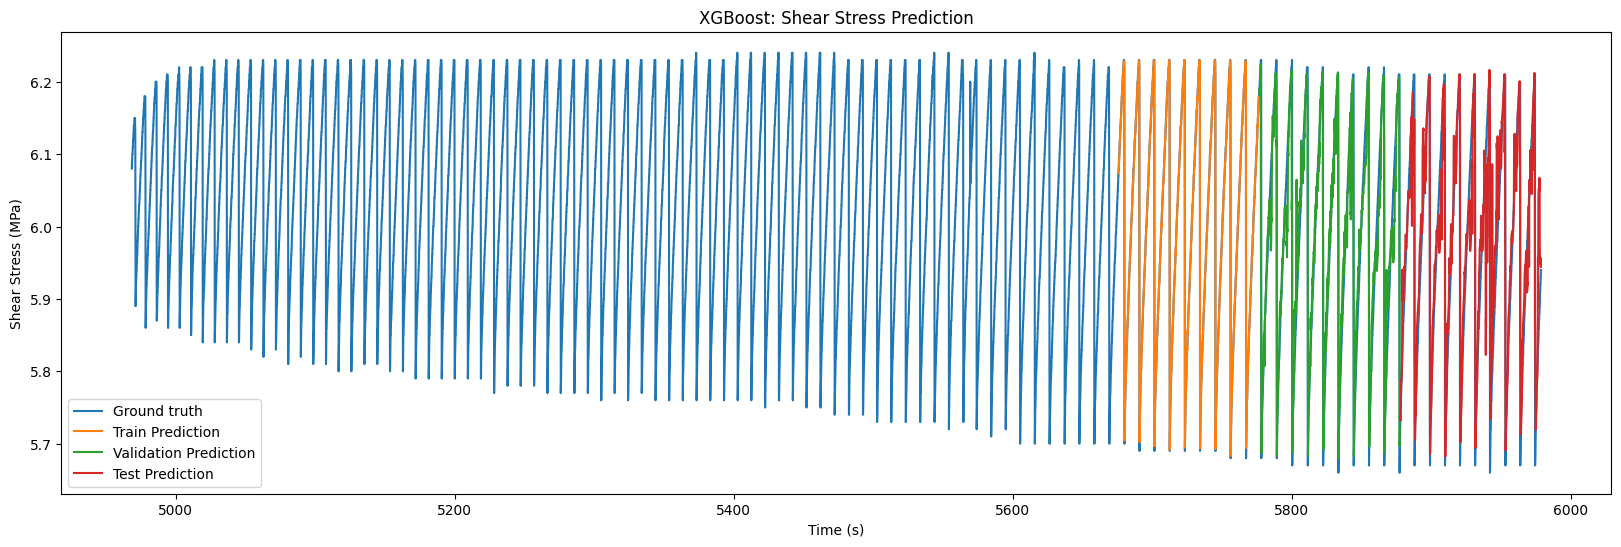

In [ ]:
# Overall plot: SS
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

traintime = traintime[6580:7520]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf[:,0])
plt.plot(traintime, y_predTrain.iloc[:,0])
plt.plot(valtime, y_predVal.iloc[:,0])
plt.plot(testtime, y_predTest.iloc[:,0])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Shear Stress Prediction')

Text(0.5, 1.0, 'XGBoost: TTF Prediction')

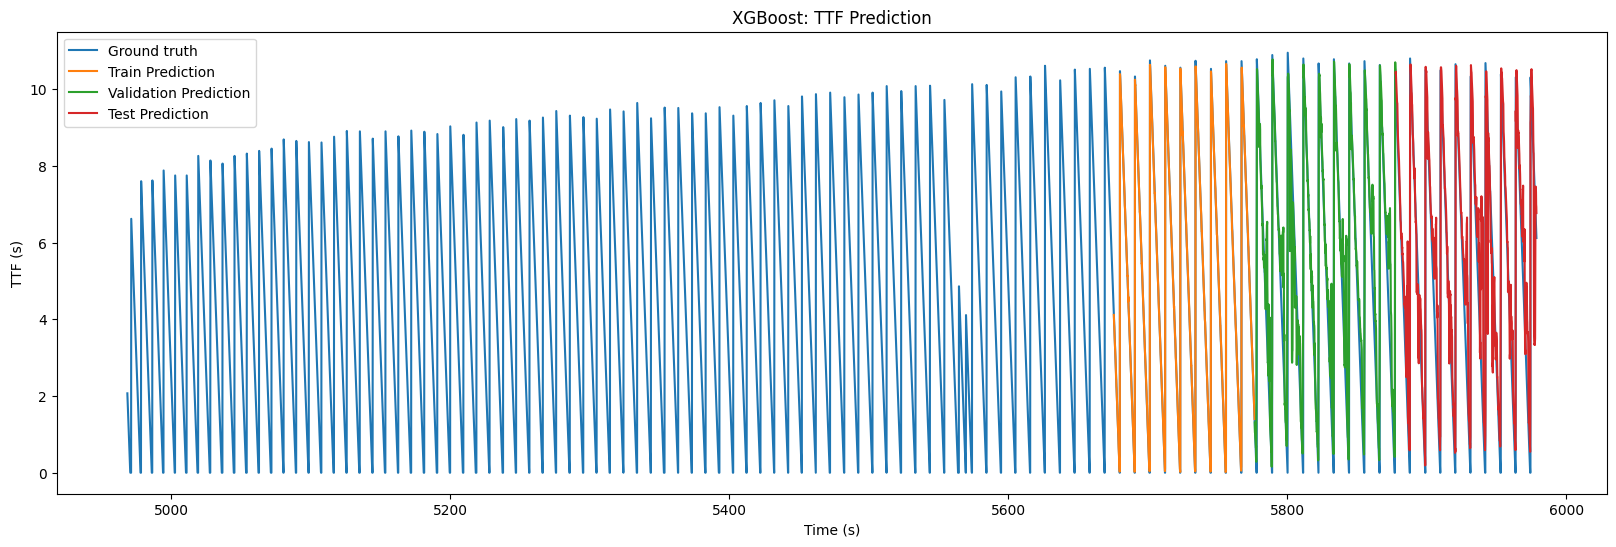

In [ ]:
# Overall plot: TTF
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

traintime = traintime[6580:7520]

## TTF
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf[:,1])
plt.plot(traintime, y_predTrain.iloc[:,1])
plt.plot(valtime, y_predVal.iloc[:,1])
plt.plot(testtime, y_predTest.iloc[:,1])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: TTF Prediction')

In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Data')
Data1 = loadmat('p5763_Set1_Inputs.mat')
Data2 = loadmat('p5763_Set1_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['AE','ln_V_V0']]
xdf = df[['AE']]
ydf = df[['ln_V_V0']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         AE
0     2.00
1     2.00
2     2.00
3     2.00
4     1.67
...    ...
9495  2.00
9496  2.00
9497  1.67
9498  1.67
9499  1.50

[9500 rows x 1 columns]
Target Data:
       ln_V_V0
0      -11.51
1      -11.51
2      -11.51
3      -11.51
4      -11.51
...       ...
9495   -11.51
9496   -11.51
9497   -11.51
9498   -11.51
9499   -11.51

[9500 rows x 1 columns]


In [ ]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1:]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Preprocessing
arr = df.to_numpy()
n_steps = 100
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (9400, 100, 1)
Target shape, Y =  (9400, 1)
After reshaping, X =  (9400, 100)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state = 0, test_size=0.111, shuffle=False)

# # Select Train
X_train = X_train[6580:7520]
Y_train = Y_train[6580:7520]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples:", np.shape(Y_train))
print("Validation output samples:", np.shape(Y_val))
print("Testing output samples:", np.shape(y_test))

Training input samples: (940, 100)
Validation input samples: (940, 100)
Testing input samples: (940, 100)
Training output samples: (940, 1)
Validation output samples: (940, 1)
Testing output samples: (940, 1)


In [ ]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
model = multioutput.MultiOutputRegressor(model)
start_time = time.time()
model.fit(X_train, Y_train, verbose=True)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

---Training time: 0.60950494 seconds ---


In [ ]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))
sr_train_r2 = r2_score(Y_train, y_predTrain)
sr_train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))
sr_val_r2 = r2_score(Y_val, y_predVal)
sr_val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))
sr_test_r2 = r2_score(y_test, y_predTest)
sr_test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

## Print
print('\nSlip rate')
print('R2 score:', sr_train_r2, sr_val_r2, sr_test_r2, '\nRMSE:', sr_train_rmse, sr_val_rmse , sr_test_rmse)


Slip rate
R2 score: 0.9997491201321554 0.6986413481099993 0.8179227171119473 
RMSE: 0.021662963328035353 0.7905690495402541 0.5877018441712047


Text(0.5, 1.0, 'XGBoost: Slip Rate Prediction')

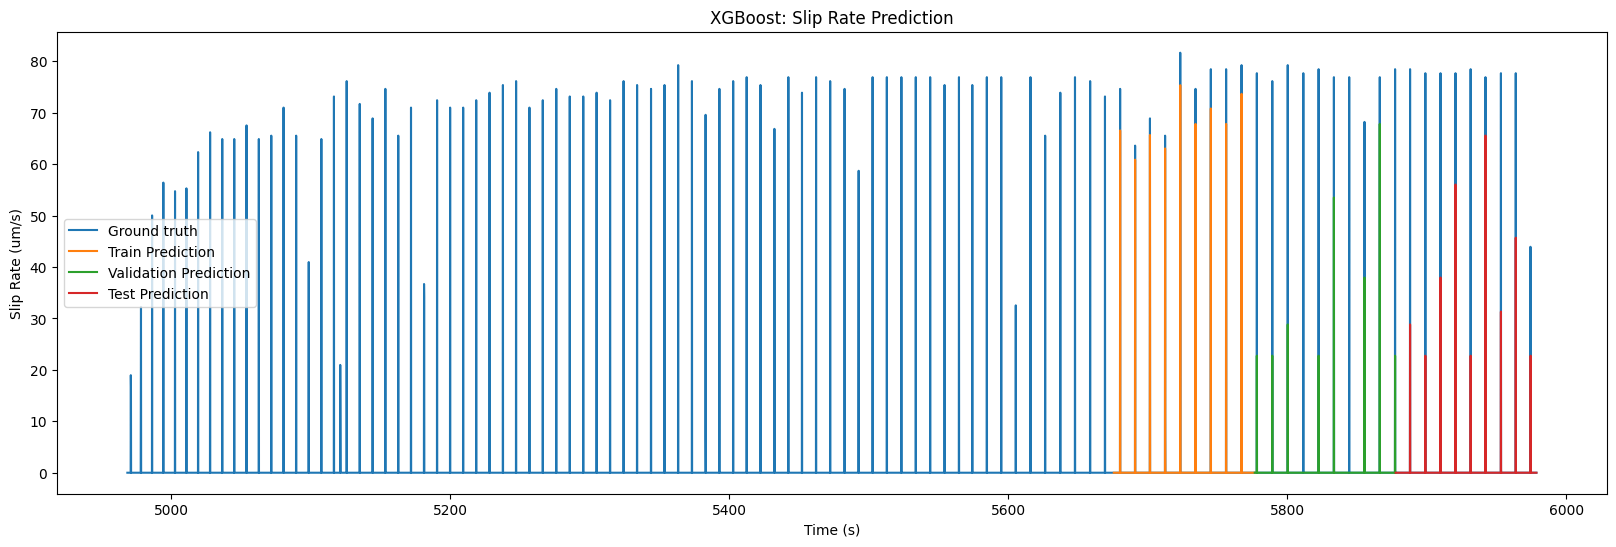

In [ ]:
# Overall plot: Slip Rate
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

traintime = traintime[6580:7520]

# Scale
ydf_scale = ydf
ydf_scale = np.exp(ydf_scale)*10;

y_predTrain_scale = y_predTrain
y_predTrain_scale = np.exp(y_predTrain_scale)*10;

y_predVal_scale = y_predVal
y_predVal_scale = np.exp(y_predVal_scale)*10;

y_predTest_scale = y_predTest
y_predTest_scale = np.exp(y_predTest_scale)*10;

## SR
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_scale)
plt.plot(traintime, y_predTrain_scale)
plt.plot(valtime, y_predVal_scale)
plt.plot(testtime, y_predTest_scale)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Slip Rate Prediction')